<a href="https://colab.research.google.com/github/airctic/mantisshrimp/blob/master/notebooks/efficientdet_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use EfficientDet

## Installing IceVision

We will install the IceVision latest version from its GitHub repo (master branch) 

In [ ]:
!pip install git+git://github.com/airctic/mantisshrimp.git#egg=mantisshrimp[all] --upgrade

## Imports

In [2]:
from mantisshrimp.all import *

## Common part to all models

### Loading Data

In [ ]:
data_dir = datasets.pets.load()

### Parser

In [ ]:
class_map = datasets.pets.class_map()

In [7]:
parser = datasets.pets.parser(data_dir, class_map)

In [18]:
data_splitter = RandomSplitter([.8, .2])
train_records, valid_records = parser.parse(data_splitter)

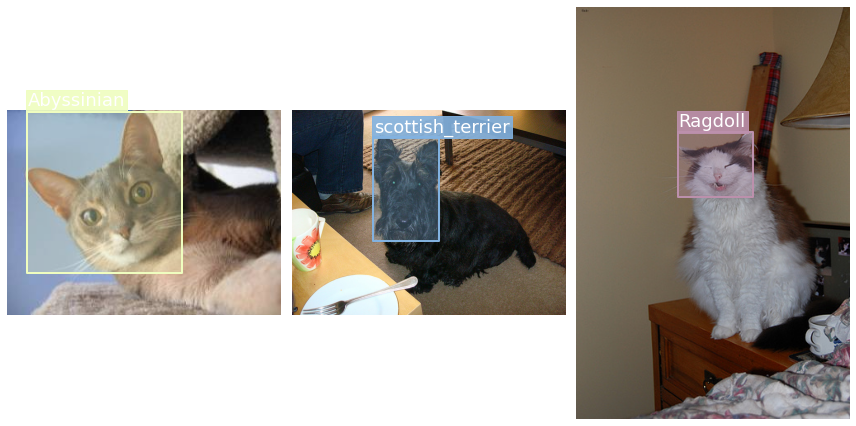

In [19]:
show_records(train_records[:3], ncols=3, class_map=class_map)

### Datasets

In [20]:
presize = 512
size = 384

In [21]:
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

In [22]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

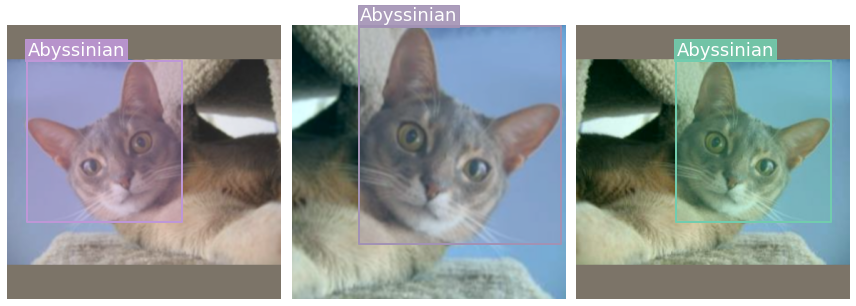

In [23]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3, class_map=class_map, denormalize_fn=denormalize_imagenet)

## EffecientDet Specific Part

### DataLoaders

In [24]:
train_dl = efficientdet.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = efficientdet.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

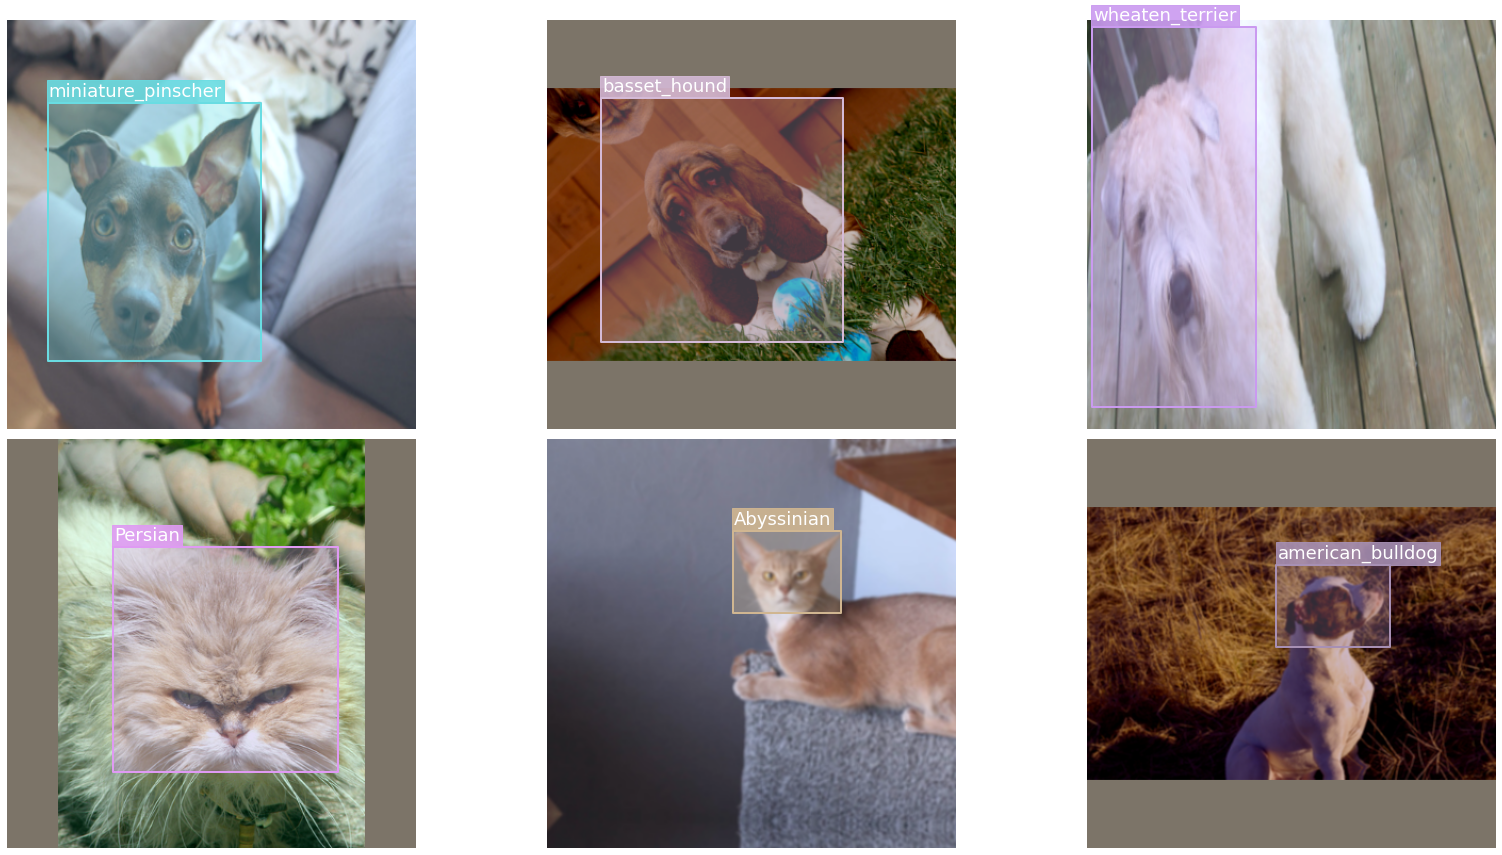

In [25]:
batch, samples = first(train_dl)
show_samples(samples[:6], class_map=class_map, ncols=3, denormalize_fn=denormalize_imagenet)

### Model

In [ ]:
model = efficientdet.model(model_name='tf_efficientdet_lite0', num_classes=len(class_map), img_size=size)

### Fastai Learner 

In [27]:
metrics = [COCOMetric()]

In [28]:
learn = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

### Fastai Training

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

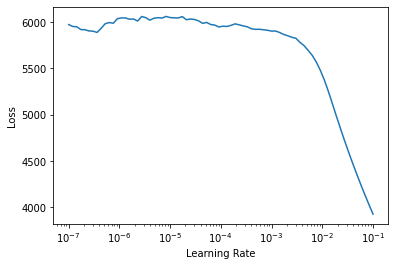

In [29]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.fine_tune(10, 1e-2, freeze_epochs=1)

/usr/local/lib/python3.6/dist-packages/fastai2/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx = (pos >= pcts).nonzero().max()


## Inference
### DataLoader

In [ ]:
infer_dl = efficientdet.infer_dl(valid_ds, batch_size=8)

### Predict

In [ ]:
samples, preds = efficientdet.predict_dl(model, infer_dl)

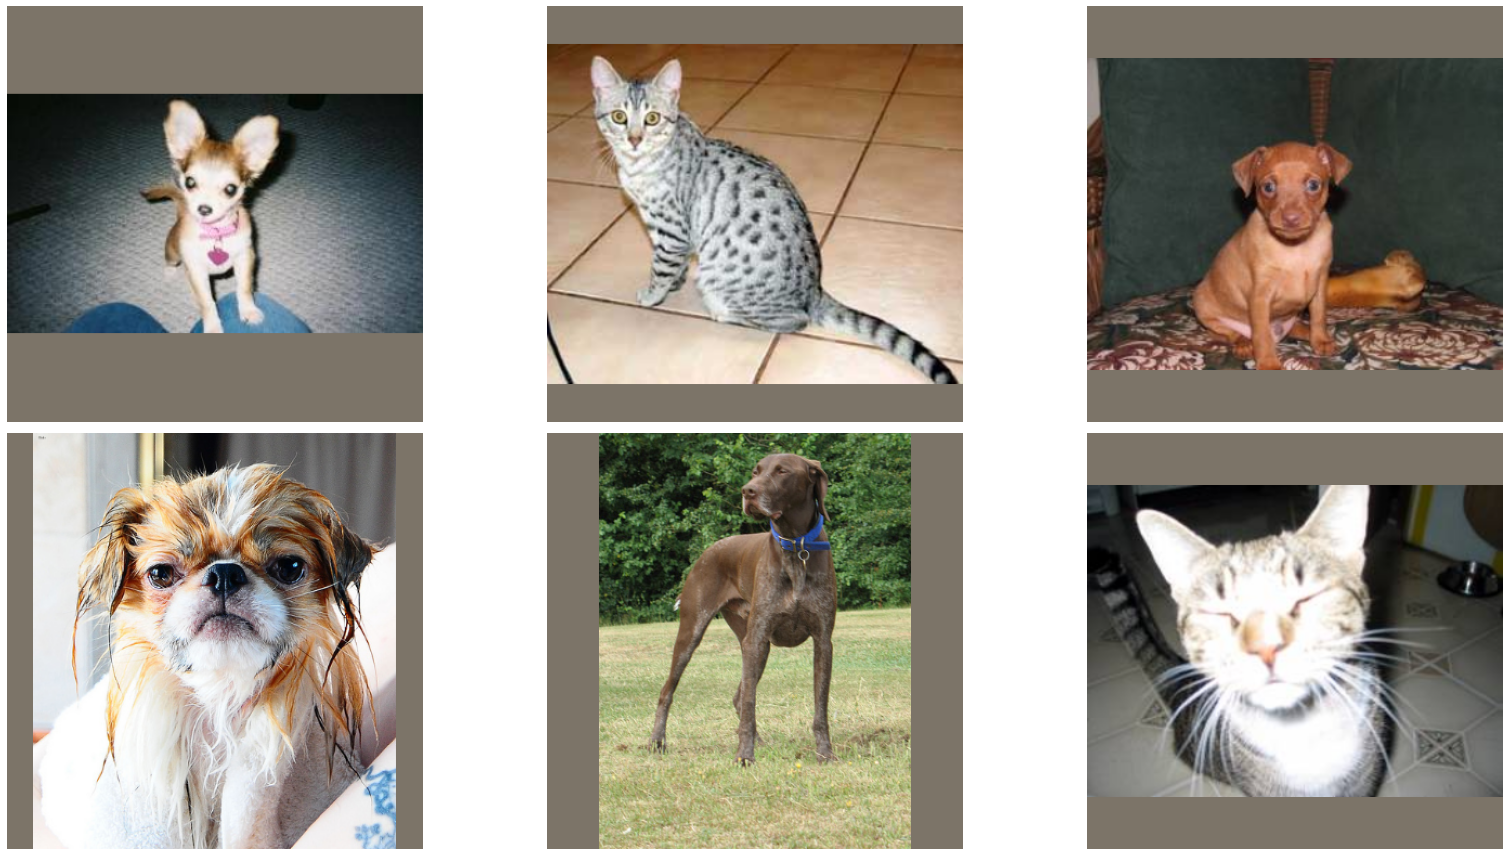

In [ ]:
imgs = [sample['img'] for sample in samples]
show_preds(imgs=imgs[:6], preds=preds[:6], class_map=class_map, denormalize_fn=denormalize_imagenet, ncols=3)

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://spectrum.chat/mantis).